In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# Constants
label_title_padding = 10
RECITATION_THRESHOLD = 10

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
memories_path = "usvsnsp/generation-semantic-filters"
target_split = "pile_deduped_12b"
pile_frame = load_dataset(memories_path, split=target_split).to_pandas()
pile_frame["Memorized"] = pile_frame["memorization_score"] >= 1
print(f"Loaded {len(pile_frame)} examples from {memories_path}/{target_split}")
pile_frame.head(1)

Loaded 5000000 examples from usvsnsp/generation-semantic-filters/pile_deduped_12b


,sequence_id,tokens,text,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,...,0_8_templates,0_9_templates,huffman_coding_length,memorization_score,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Memorized
0,3195,"[273, 253, 6115, 1159, 275, 5238, 905, 16314, ...",of the Green function in Section \[proof2\].\...,False,False,2,11740996961,1.737210e+09,466618,91844186.5,...,1,1,5.036364,0.0,3195,2.480469,4.364043,2.667871,11.642706,False


In [3]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

pile_frame["Category"] = pile_frame.progress_apply(get_category, axis=1)
pile_frame["Category"].value_counts()

100%|██████████| 5000000/5000000 [00:09<00:00, 546397.87it/s]


Category
Not Memorized     4946005
Recitation          41880
Recollection        11130
Reconstruction        985
Name: count, dtype: int64

In [18]:
pile_frame["is_code"] = pile_frame["nl_scores"].progress_apply(lambda x: x <= 0.45)

100%|██████████| 5000000/5000000 [00:01<00:00, 4992671.04it/s]


generation_perplexity                                          \
                          count      mean       std       min       25%   
Memorized                                                                 
False                 4839838.0  3.419192  1.620504  1.010721  2.333272   
True                    12382.0  1.026164  0.024413  1.000009  1.007694   

                                          
                50%       75%        max  
Memorized                                 
False      3.192831  4.166949  79.729668  
True       1.019247  1.037334   1.200819

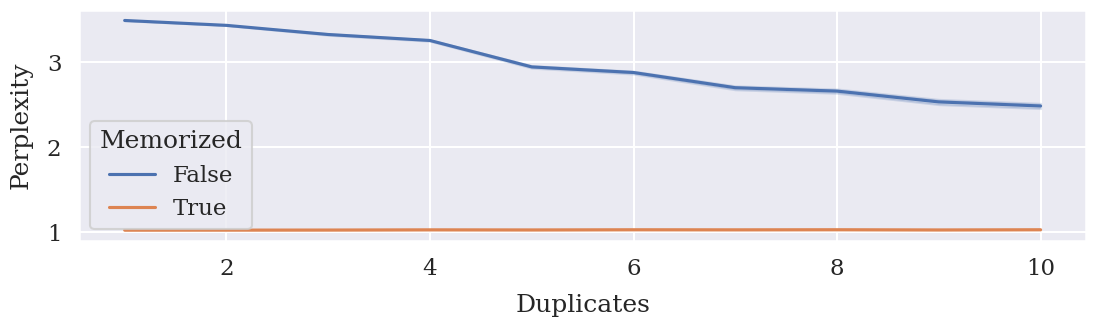

In [19]:
plotting_frame = pile_frame[pile_frame["sequence_duplicates"] <= 10]
display(plotting_frame[["Memorized", "generation_perplexity"]].groupby("Memorized").describe())

# Plot lineplot
sns.lineplot(data=plotting_frame, x="sequence_duplicates", y="generation_perplexity", hue="Memorized", errorbar="ci")

# y label is "Perplexity" and x label is "Duplicates"
plt.xlabel("Duplicates", labelpad=label_title_padding)
plt.ylabel("Perplexity", labelpad=label_title_padding)

# set figure dimensions
plt.gcf().set_size_inches(13, 3)

# log x axis
# plt.xscale("log")

In [20]:
max_memorized_perplexity = plotting_frame[plotting_frame["Memorized"] == False]["generation_perplexity"].quantile(0.99)
max_memorized_perplexity

8.445495252609252

In [21]:
examples_below_ppl_thrrshold = plotting_frame[plotting_frame["generation_perplexity"] <= max_memorized_perplexity]
examples_below_ppl_thrrshold.value_counts("Memorized", normalize=True)

Memorized
False    0.997422
True     0.002578
Name: proportion, dtype: float64

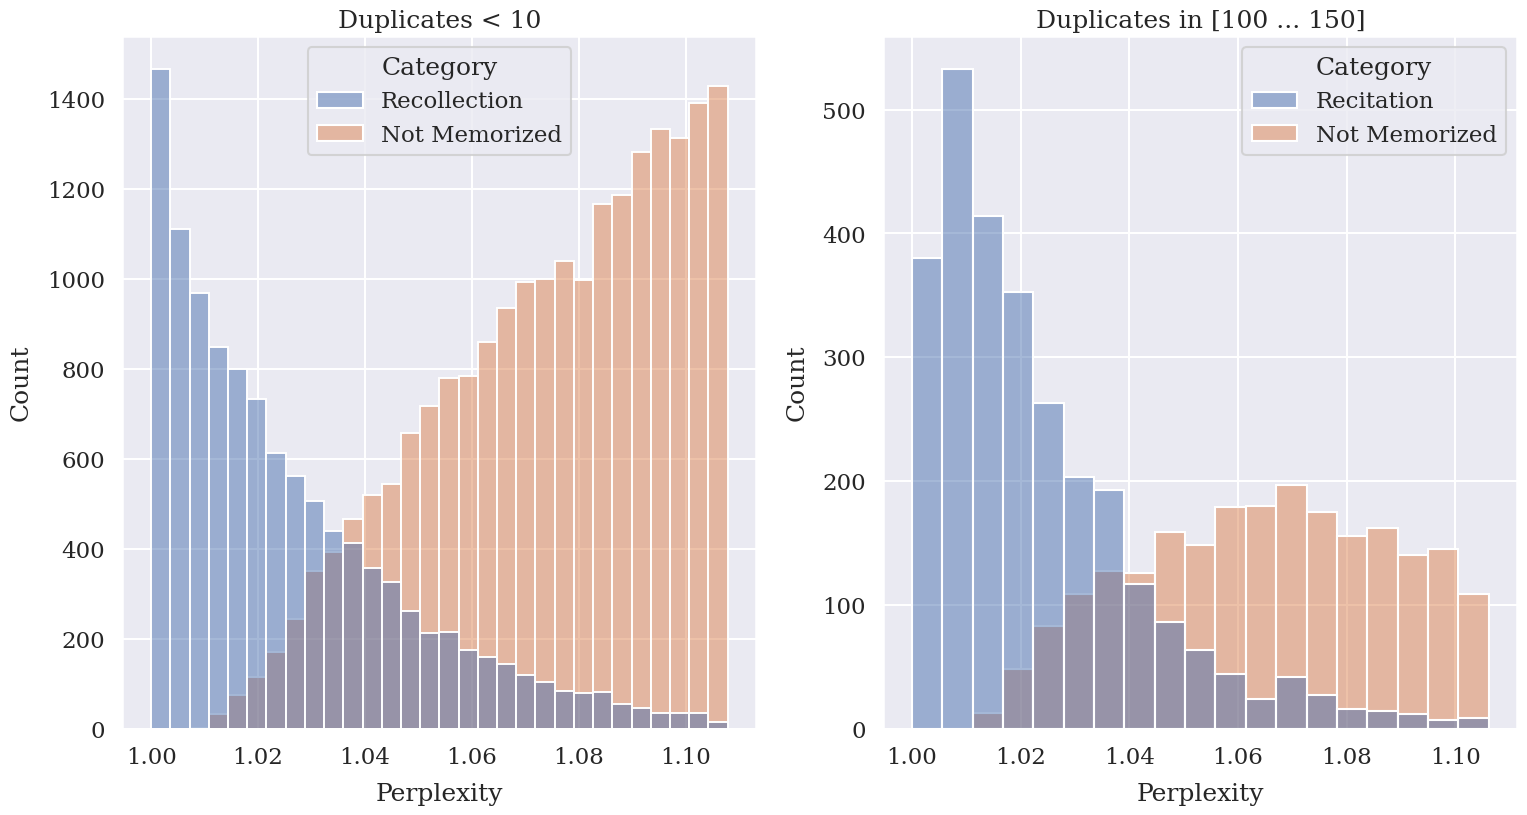

In [22]:
# TWO HISTOGRAMS
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

plotting_frames = [
    # duplicates less than 10
    pile_frame[pile_frame["sequence_duplicates"] < 10],
    # duplicates in the range of 100 ... 150
    pile_frame[(pile_frame["sequence_duplicates"] >= 100) & (pile_frame["sequence_duplicates"] <= 150)]
]

for i, plotting_frame in enumerate(plotting_frames):
    p95_memeorization_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.99)
    hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_memeorization_ppl]
    # filter out Reconstructions
    hist_data_12b = hist_data_12b[hist_data_12b["Category"] != "Reconstruction"]

    # hist should be transparent to show both
    sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="Category", multiple="layer", ax=ax[i])

    ax[i].set_xlabel("Perplexity", labelpad=label_title_padding)
    ax[i].set_ylabel("Count", labelpad=label_title_padding)

    # set titles
    if i == 0:
        ax[i].set_title("Duplicates < 10")
        # remove legend
        # ax[i].get_legend().remove()
    else:
        ax[i].set_title("Duplicates in [100 ... 150]")
        # center legend below both plots
        # ax[i].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), shadow=True, ncol=2, labels=["Memorized", "Not Memorized"], frameon=False)

# add padding between plots
# plt.tight_layout()

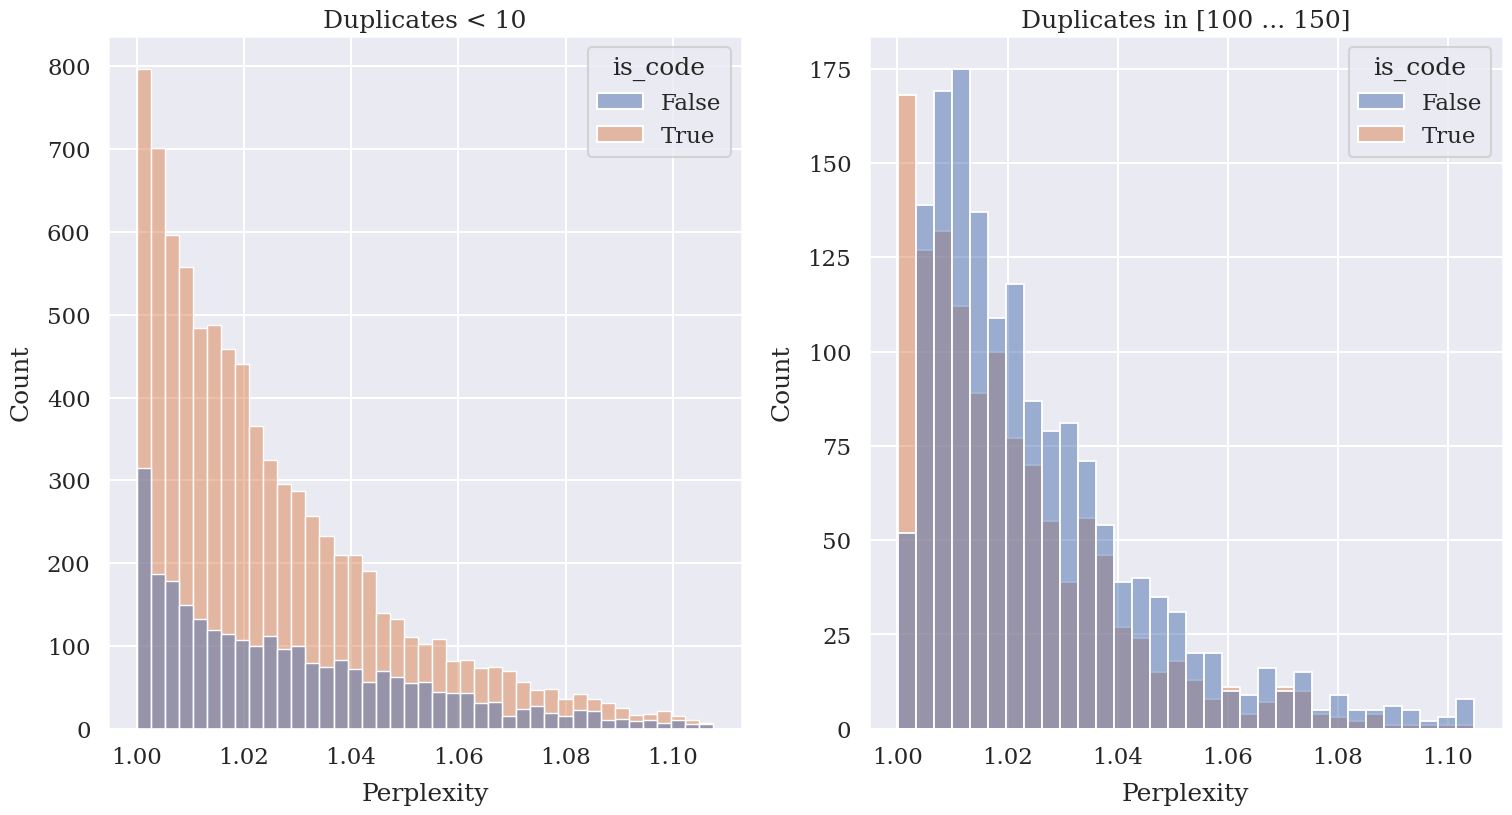

In [23]:
# TWO HISTOGRAMS
fig, ax = plt.subplots(1, 2, figsize=(18, 9))

plotting_frames = [
    # duplicates less than 10
    pile_frame[(pile_frame["sequence_duplicates"] < 10) & (pile_frame["Memorized"] == True)],
    # duplicates in the range of 100 ... 150
    pile_frame[(pile_frame["sequence_duplicates"] >= 100) & (pile_frame["sequence_duplicates"] <= 150) & (pile_frame["Memorized"] == True)]
]

for i, plotting_frame in enumerate(plotting_frames):
    p95_memeorization_ppl = plotting_frame[plotting_frame["Memorized"] == True]["generation_perplexity"].quantile(0.99)
    hist_data_12b = plotting_frame[plotting_frame["generation_perplexity"] <= p95_memeorization_ppl]
    # filter out Reconstructions
    hist_data_12b = hist_data_12b[hist_data_12b["Category"] != "Reconstruction"]

    # hist should be transparent to show both
    sns.histplot(data=hist_data_12b, x="generation_perplexity", hue="is_code", multiple="layer", ax=ax[i])

    ax[i].set_xlabel("Perplexity", labelpad=label_title_padding)
    ax[i].set_ylabel("Count", labelpad=label_title_padding)

    # set titles
    if i == 0:
        ax[i].set_title("Duplicates < 10")
        # remove legend
        # ax[i].get_legend().remove()
    else:
        ax[i].set_title("Duplicates in [100 ... 150]")
        # center legend below both plots
        # ax[i].legend(loc='upper center', bbox_to_anchor=(-0.1, -0.15), shadow=True, ncol=2, labels=["Memorized", "Not Memorized"], frameon=False)

# add padding between plots
# plt.tight_layout()